In [171]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [172]:
def plot_background_fct(send_data, recv_data, label, do_plot=True):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Background FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [173]:
def plot_foreground_fct(send_data, recv_data, label, do_plot=True):
    # diffs in micrseconds
    diffs = (recv_data - send_data) * 1000 * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Foreground FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Microseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [174]:
def plot_fanout(send_data, recv_data, label, do_plot=True, res_type="max"):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if res_type=="max":
        diffs = np.max(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="avg":
        diffs = np.mean(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="min":
        diffs = np.min(diffs[:,:diffs.shape[1]-1],1)
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="RCT"+label) 
        ax1.set_title("Partition/Aggregate query completion time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Query ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [209]:
def servers_within_deadline(send_data, recv_data, deadline = 20):
    # diffs and deadline in miliseconds
    diffs = (recv_data - send_data) * 1000.0
    diffs_within_deadline = diffs < deadline
    num_serv_that_meet_deadline = np.sum(diffs_within_deadline,1)
    return np.mean(num_serv_that_meet_deadline), np.percentile(num_serv_that_meet_deadline,1)

In [210]:
a = np.array([[1,2,3,4,5,1,7],[2,4,7,1,8,4,1,]])
b=a<4
print(b)
c = np.sum(b,1)
print(c)

[[ True  True  True False False  True False]
 [ True False False  True False False  True]]
[4 3]


In [211]:
def plot_queue_size(data, label, do_plot=True):
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [212]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    results in microseconds
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing microseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [213]:
def print_results(fore=True, back=True, fanout_max=True, fanout_avg=True, fanout_min=True):
    print("Mean Q length in Kbytes {0} and in packets {1}\n99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}\n".format(delay_mean, delay_99))
    if fore:
        print("Foreground FCT (us): mean: {0}, 99th %: {1}\n".format(frg_mean, frg_99))
    if back:
        print("Background FCT (ms): mean: {0}, 99th %: {1}\n".format(bkg_mean, bkg_99))
    if fanout_max:
        print("Fanout max QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_max_mean, fan_max_99))
    if fanout_avg:
        print("Fanout avg QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_avg_mean, fan_avg_99))
    if fanout_min:
        print("Fanout min QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_min_mean, fan_min_99))
        print("Servers in deadline: mean: {0}, 99th %: {1}\n".format(servers_mean, servers_99))
        
    
    
    #print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

## Just fanout, workload 1 at 30% - 10 flows

In [214]:
results_folders = ["/TCP/", "/DCTCP30/", "/DCTCP_pacer_PQ/"]
latency = dict()
bkg_fct = dict()
frg_fct = dict()
fanout_qct_max = dict()
fanout_qct_avg = dict()
fanout_qct_min = dict()
servers_in_deadline = dict()



for folder in results_folders:
    latency[folder] = []
    bkg_fct[folder] = []
    frg_fct[folder] = []
    fanout_qct_max[folder] = []
    fanout_qct_avg[folder] = []
    fanout_qct_min[folder] = []    
    servers_in_deadline[folder] = []        

In [215]:
simul_folder = "onlyfanout_wkld1_30_10flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, 20)
    
    print(folder)
    print_results(fore=False, back=False, fanout_max=True, fanout_avg=True, fanout_min=True)
    
    """
    (0,1484)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,0)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1281)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,0)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10  9
  9  9  9  8 10 10 10 10 10 10 10 10 10 10 10 10]
/TCP/
Mean Q length in Kbytes 0.0015321006270788598 and in packets 0.0027573506010255544
99th percentile in Kbytes 0.011477501352366208 and in packets 0.01855625382818478

Mean delay in us 0.012256805016630878 and 99th percentile delay in us 0.09182001081892967

Fanout max QCT (ms): mean: 11.861691827033336, 99th %: 30.592449654056097

Fanout avg QCT (ms): mean: 4.1467681495415905, 99th %: 10.337442728251556

Fanout min QCT (ms): mean: 0.6328319526961736, 99th %: 2.820076103245623

Servers in deadline: mean: 9.89363137916491, 99th %: 8.0

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9 10 10 10 10 10 10 10  9
  9  9  9  8 10 10 10 10 10 10 10 10 10 10 10 10]
/DCTCP30/
Mean Q length in Kbytes 0.0015321006270788598 and in packets 0.0027573506010255544
99th percentile in Kbytes 0.011477501352366208 and in packets 0.01855625382818478

Mean delay in us 0.01225680501663

## Fanout, workload 1 at 30% + background traffic at 200Mbps - 10 flows 

In [200]:
simul_folder = "bkg200_fanout_wkld1_30_10flows"

for folder in results_folders:
    path = simul_folder + folder
    q_mon = np.genfromtxt(path+"q_mon", delimiter=" ")
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=False)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=False)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = np.genfromtxt(path+"send_times|background.csv", delimiter=" ")
    bkg_recv = np.genfromtxt(path+"rec_times|background.csv", delimiter=" ")
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = np.genfromtxt(path+"send_times|fanout.csv", delimiter=",")
    fan_recv = np.genfromtxt(path+"rec_times|fanout.csv", delimiter=",")
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, 20)
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,1695)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,12071)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1396)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,40)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


/TCP/
Mean Q length in Kbytes 24.628110090979828 and in packets 25.768533059783728
99th percentile in Kbytes 267.3721422728311 and in packets 279.7298486201625

Mean delay in us 197.02488072783862 and 99th percentile delay in us 2138.9771381826495

Background FCT (ms): mean: 109.92766356092046, 99th %: 318.0634533299275

Fanout max QCT (ms): mean: 12.549892728325995, 99th %: 31.821353152573664

Fanout avg QCT (ms): mean: 4.792751314334563, 99th %: 12.895179087839015

Fanout min QCT (ms): mean: 1.216873200571218, 99th %: 7.194570282529608

Servers in deadline: mean: 9.865457612821594, 99th %: 8.0

/DCTCP30/
Mean Q length in Kbytes 3.56749393958872 and in packets 3.694621269419423
99th percentile in Kbytes 20.609013640623832 and in packets 22.046261722171632

Mean delay in us 28.53995151670976 and 99th percentile delay in us 164.87210912499066

Background FCT (ms): mean: 114.41642104599012, 99th %: 280.4406935408957

Fanout max QCT (ms): mean: 12.081964333129303, 99th %: 31.0663018564570

In [164]:
print("--------latency----------")
print(latency)
print("--------bkg----------")
print(bkg_fct)
print("--------fan_max----------")
print(fanout_qct_max)
print("--------fan_avg---------")
print(fanout_qct_avg)
print("--------fan_min---------")
print(fanout_qct_min)


--------latency----------
{'/TCP/': [(0.012256805016630878, 0.09182001081892967), (197.02488072783862, 2138.9771381826495)], '/DCTCP30/': [(0.012256805016630878, 0.09182001081892967), (28.53995151670976, 164.87210912499066)], '/DCTCP_pacer_PQ/': [(0.011402435507357337, 0.07736876960638275), (0.6277829051128065, 15.210358573679539)]}
--------bkg----------
{'/TCP/': [(109.92766356092046, 318.0634533299275)], '/DCTCP30/': [(114.41642104599012, 280.4406935408957)], '/DCTCP_pacer_PQ/': [(243.65444273656223, 367.2316272451263)]}
--------fan_max----------
{'/TCP/': [(11.861691827033336, 30.592449654056097), (12.549892728325995, 31.821353152573664)], '/DCTCP30/': [(11.861691827033336, 30.592449654056097), (12.081964333129303, 31.06630185645709)], '/DCTCP_pacer_PQ/': [(11.90204503855953, 30.878126218570618), (11.972514519775682, 31.248185067426206)]}
--------fan_avg---------
{'/TCP/': [(4.1467681495415905, 10.337442728251556), (4.792751314334563, 12.895179087839015)], '/DCTCP30/': [(4.146768149

Text(0, 0.5, 'Microseconds')

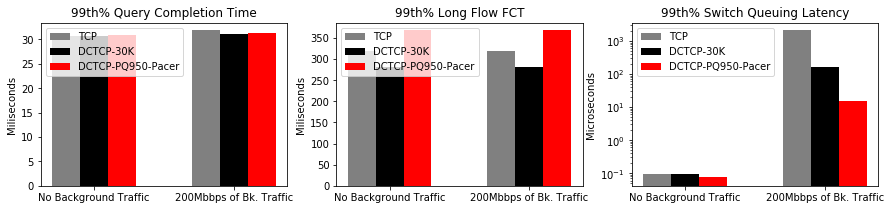

In [165]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
config_num = 2
ind = np.arange(config_num)
width = 0.2
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_max[folder]])
p1 = ax1.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax1.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax1.bar(ind+1.5*width, res[2], width, color='r')


ax1.set_title('99th% Query Completion Time')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(('No Background Traffic', '200Mbbps of Bk. Traffic', '400Mbbps of Bk. Traffic', '600Mbbps of Bk. Traffic'))
ax1.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
ax1.set_ylabel('Miliseconds')

# Long flow fct
res = []
for folder in results_folders:
    res.append([x[1] for x in bkg_fct[folder]])
p1 = ax2.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax2.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax2.bar(ind+1.5*width, res[2], width, color='r')


ax2.set_title('99th% Long Flow FCT')
ax2.set_xticks(ind + width / 2)
ax2.set_xticklabels(('No Background Traffic', '200Mbbps of Bk. Traffic', '400Mbbps of Bk. Traffic', '600Mbbps of Bk. Traffic'))
ax2.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
ax2.set_ylabel('Miliseconds')

# Switch Latency
res = []
for folder in results_folders:
    res.append([x[1] for x in latency[folder]])
p1 = ax3.bar(ind-0.5*width, res[0], width, color='grey',log=True)
p2 = ax3.bar(ind+0.5*width, res[1], width, color='k',log=True)
p3 = ax3.bar(ind+1.5*width, res[2], width, color='r',log=True)


ax3.set_title('99th% Switch Queuing Latency')
ax3.set_xticks(ind + width / 2)
ax3.set_xticklabels(('No Background Traffic', '200Mbbps of Bk. Traffic', '400Mbbps of Bk. Traffic', '600Mbbps of Bk. Traffic'))
ax3.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc='upper left')
ax3.set_ylabel('Microseconds')

In [128]:
# fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16,10))
# for i, setup in enumerate(results_folders):
#     ax1.bar(i-0.4, latency[setup][0][0], width=0.1, log=True, color="blue")
#     ax1.bar(i-0.3, latency[setup][0][1], width=0.1, log=True, color="blue")
#     ax1.bar(i-0.1, latency[setup][1][0], width=0.1, log=True, color="red")
#     ax1.bar(i, latency[setup][1][1], width=0.1, log=True, color="red")
#     ax1.bar(i+0.2, latency[setup][2][0], width=0.1, log=True, color="green")
#     ax1.bar(i+0.3, latency[setup][2][1], width=0.1, log=True, color="green")
# ax1.set_title("Switch Latency")
# ax1.legend(loc='upper left')
# ax1.set_ylabel('Queuing miliseconds')
# ax1.set_xlabel('Scheme')
# ax1.grid(which='major', linestyle="-")
# #ax1.grid(which='minor', linestyle='--')

# fig.tight_layout()   

# fig.savefig("Queuing delay vs Time.png", format="png")
# fig.show()